In [9]:
!apt-get install -y python3-opencv
%pip install opencv-python

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
python3-opencv is already the newest version (4.5.4+dfsg-9ubuntu4).
0 upgraded, 0 newly installed, 0 to remove and 33 not upgraded.
Note: you may need to restart the kernel to use updated packages.


In [10]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


###### the code below edited from https://docs.opencv.org/3.4/d1/de0/tutorial_py_feature_homography.html
#### Import requirements

In [1]:
#import requirements
import torch
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

#### Read the images
###### the images from https://www.kaggle.com/datasets/manuelnkegoum/homography data-set

In [2]:
# minimum good descriptors
MIN_MATCH_COUNT = 10

# read the images
img1 = cv.imread('images/img1.jpg', cv.IMREAD_GRAYSCALE)
img2 = cv.imread('images/img2.jpg', cv.IMREAD_GRAYSCALE)

#### Using SIFT algorithm for detect descriptors

In [3]:
# Initiate SIFT detector
sift = cv.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)

flann = cv.FlannBasedMatcher(index_params, search_params)

matchers = flann.knnMatch(des1,des2,k=2)

# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matchers:
  if m.distance < 0.5*n.distance:
    good.append(m)

len(good)

21

#### Find homography

In [4]:
from time import time
from pytorch_homography import find_homography

if len(good) > MIN_MATCH_COUNT:
  src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1,1,2)
  dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1,1,2)
  t = time()
  M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)
  print(f'cv.findHomography time: {time()-t}')
  matchesMask = mask.ravel().tolist()
  h,w = img1.shape
  pts = np.float32([[0,0],[0,h-1],[w-1,h-1],[w-1,0]]).reshape(-1,1,2)
  dst = cv.perspectiveTransform(pts,M)
  img2 = cv.polylines(img2,[np.int32(dst)],True,255,3, cv.LINE_AA)
  torch.use_deterministic_algorithms(False)
  if torch.cuda.is_available():
    x = torch.from_numpy(src_pts).cuda().reshape(-1,2)
    y = torch.from_numpy(dst_pts).cuda().reshape(-1,2)
  else:
    x = torch.from_numpy(src_pts).reshape(-1,2)
    y = torch.from_numpy(dst_pts).reshape(-1,2)
  # run our find_homography algorithm based on ransac
  t = time()
  homog, num_matches = find_homography(x, y)
  print(f'pytorch_homography time: {time()-t}')
  print(f'num matches: {num_matches}')
  print(homog)
  if torch.cuda.is_available():
    homog = homog.cpu()
  our_transformed = cv.warpPerspective(img1, homog.numpy(), (h, w))
  cv_transformed = cv.warpPerspective(img1, M, (h, w))
else:
  print("not enough matches")

cv.findHomography time: 0.0011887550354003906
pytorch_homography time: 0.048573970794677734
num matches: 21
tensor([[ 6.6449e-01,  7.5484e-02,  3.9128e+00],
        [-1.6542e-01,  1.1056e+00,  9.5717e+00],
        [-1.6133e-03,  2.5062e-04,  1.0000e+00]])


#### Draw matches

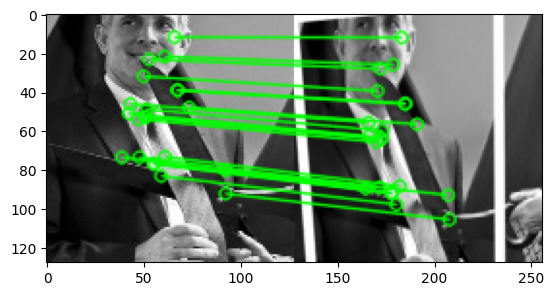

(<matplotlib.image.AxesImage at 0x7ff0e0200d60>, None)

In [5]:
# draw the cv homography match
draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = None,
                   matchesMask = matchesMask,
                   flags = 2)
img3 = cv.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)
plt.imshow(img3, 'gray'),plt.show()

#### Our results

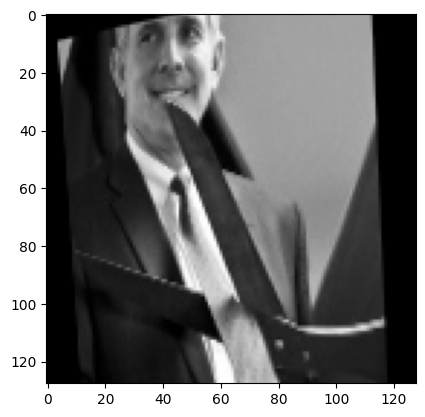

(<matplotlib.image.AxesImage at 0x7ff0e011d390>, None)

In [6]:
# print the image transformed from our homography algorithm
plt.imshow(our_transformed, 'gray'),plt.show()

#### CV2 results

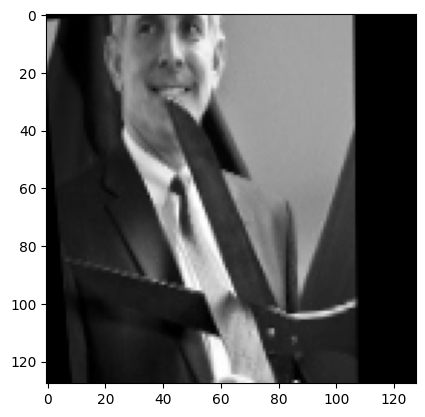

(<matplotlib.image.AxesImage at 0x7ff0e0178dc0>, None)

In [7]:
# print the image transformed from cv2 homography algorithm
plt.imshow(cv_transformed, 'gray'),plt.show()